In [1]:
import steam
import pandas as pd
import numpy as np
from rake_nltk import Rake
import matplotlib.pyplot as plt; plt.rcdefaults()
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from steam.api import interface
steam.api.key.set('FC864146AEF094845C669F86F0B20CFF')
pd.options.display.float_format = '{:,.5f}'.format

In [2]:
steam_games = pd.read_csv('steam_games_all_fields.csv', index_col=0, delimiter='\t')
app_id = steam_games['steam_url'].str.split('/',expand=True)
app_id = app_id.drop([0, 1, 2, 5, 6], axis=1)
app_id.columns = ['app', 'game_ID']
df = pd.concat([steam_games, app_id], axis=1, sort=False)
df['description'] = df['description'].fillna('')
df = df[~df.description.str.contains('no description')]
df['release_date'] = df['release_date'].replace({'no release date' : ''})
df['game_title'] = df['game_title'].str.replace(r'®', '')
df['game_title'] = df['game_title'].str.replace(r'™', '')
df = df.drop(['app'], axis=1)
df['game_ID'] = pd.to_numeric(df['game_ID'], downcast='signed')
df['number_of_review'] = df['number_of_review'].replace({'no reviews' : ''})
df['number_of_review'] = pd.to_numeric(df['number_of_review'], downcast='integer')
df['score'] = df['score'].replace({'no rating' : ''})
df['score'] = pd.to_numeric(df['score'])
df = df[df['number_of_review'] > 0]
#df = df[~df.game_title.str.contains('NaN')]
#df = df[~df.game_title.str.contains('NaN')]
df = df.rename(columns={"game_ID": "appid"})
df = df.rename(columns={"Unnamed: 0": "id"})
df = df.drop(['steam_url', 'image'], axis=1)
df = df.drop_duplicates(subset='appid', keep='first')
df = df.dropna(subset=['game_title'])
df = df.reset_index()
df.head(100)

,index,game_title,tags,description,number_of_review,score,release_date,appid
0,0,Counter-Strike: Global Offensive,"FPS, Multiplayer, Shooter, Action, Team-Based,...",Counter-Strike: Global Offensive (CS: GO) expa...,"2,915,091.00000",9.00000,"Aug 21, 2012",730
1,1,MONSTER HUNTER: WORLD,"Action, Hunting, Co-op, Open World, Multiplaye...",Welcome to a new world! In Monster Hunter: Wor...,"55,314.00000",6.00000,"Aug 9, 2018",582010
2,2,Path of Exile,"Free to Play, Action RPG, Hack and Slash, RPG,...","You are an Exile, struggling to survive on the...","74,977.00000",9.00000,"Oct 23, 2013",238960
3,3,Insurgency: Sandstorm,"FPS, Realistic, Shooter, Multiplayer, Action, ...","Insurgency: Sandstorm is a team-based, tactica...","9,019.00000",9.00000,"Dec 12, 2018",581320
4,4,Warframe,"Free to Play, Action, Co-op, Multiplayer, Thir...",Warframe is a cooperative free-to-play third p...,"236,593.00000",9.00000,"Mar 25, 2013",230410
5,5,Divinity: Original Sin 2 - Definitive Edition,"RPG, Turn-Based, Co-op, Story Rich, Fantasy, O...",The eagerly anticipated sequel to the award-wi...,"37,446.00000",9.00000,"Sep 14, 2017",435150
6,6,Assassin's Creed Odyssey,"Open World, Action, RPG, Singleplayer, Adventu...",Choose your fate in Assassin's Creed® Odyssey....,"14,907.00000",9.00000,"Oct 5, 2018",812140
7,7,Rocket League,"Multiplayer, Racing, Soccer, Sports, Competiti...",Soccer meets driving once again in the long-aw...,"182,330.00000",9.00000,"Jul 7, 2015",252950
8,8,Tom Clancy's Rainbow Six Siege,"FPS, Multiplayer, Tactical, Shooter, Action, T...",Tom Clancy's Rainbow Six Siege is the latest i...,"224,822.00000",9.00000,"Dec 1, 2015",359550
9,9,Grand Theft Auto V,"Open World, Action, Multiplayer, Third Person,...","Los Santos is a city of bright lights, long ni...","386,027.00000",6.00000,"Apr 14, 2015",271590


In [3]:
games = interface('IPlayerService').GetOwnedGames(steamid=76561197974553664, include_appinfo=1)
my_games = games['response']['games']
#for game in my_games:
 #   game.update({"friend_ID": 76561197974553664})
    
game_table = pd.DataFrame(my_games)
#game_table = game_table.sort_values(by=['playtime_forever'], ascending=False)
#game_table = game_table.fillna(0)
game_table = game_table.drop(['has_community_visible_stats', 'playtime_2weeks',
                              'img_icon_url', 'img_logo_url'], axis=1)
game_table.head()

,appid,name,playtime_forever
0,220,Half-Life 2,57
1,240,Counter-Strike: Source,237
2,320,Half-Life 2: Deathmatch,2
3,340,Half-Life 2: Lost Coast,0
4,1520,DEFCON,202


In [4]:
#df = pd.merge(df, game_table, how='outer', on='appid')
#df.fillna()

In [5]:
df.count()

index               20369
game_title          20369
tags                20369
description         20369
number_of_review    20369
score               20369
release_date        20369
appid               20369
dtype: int64

In [4]:
ds = df[['index' ,'appid', 'game_title', 'tags', 'description']]
tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 3), min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(ds['description'])

In [7]:
cosine_similarities = linear_kernel(tfidf_matrix, tfidf_matrix)

In [8]:
results = {}

for idx, row in ds.iterrows():
    similar_indices = cosine_similarities[idx].argsort()[:-100:-1]
    similar_items = [(cosine_similarities[idx][i], ds['appid'][i]) for i in similar_indices]

    # First item is the item itself, so remove it.
    # Each dictionary entry is like: [(1,2), (3,4)], with each tuple being (score, item_id)
    results[row['appid']] = similar_items[1:]
    
print('done!')

done!


In [9]:
#ds = ds[ds['playtime_forever'] == 0]


In [137]:
def item(id):
    return ds.loc[ds['appid'] == id]['game_title'].tolist()[0]

def recommend(item_id, num):
    print('Recommending ' + str(num) + " products similar to " + item(item_id) + '...')
    print('----------')
    recs = results[item_id][:num]
    for rec in recs:
        print('Recommended: ' + item(rec[1]) + " (score:" + str(rec[0]) + ")")
        
recommend(220, 10)

Recommending 10 products similar to Half-Life 2...
----------
Recommended: Half-Life: Source (score:0.150671158069)
Recommended: Half-Life 2: Episode One (score:0.113060686832)
Recommended: Half-Life (score:0.0873934209705)
Recommended: Arma: Cold War Assault Mac/Linux (score:0.0676011604373)
Recommended: ARMA: Cold War Assault (score:0.0676011604373)
Recommended: Sanitarium (score:0.0496240338094)
Recommended: The Solus Project (score:0.0492478339419)
Recommended: Left 4 Dead (score:0.0491373414274)
Recommended: Sid Meier's Civilization IV (score:0.0473298758765)
Recommended: Civilization IV: Beyond the Sword (score:0.0468565120734)


In [141]:
def item(id):
    return ds.loc[ds['appid'] == id]['game_title'].tolist()[0]

#item_id = 220
#num = 5

def recommend(item_id, num):
    print('Recommending ' + str(num) + " games sitting in your Steam library unplayed, that are similar to " + 
          item(item_id) + '.')

    rez = results[item_id]
    #print(rez)
    df_test = pd.DataFrame(rez, columns=['sim_score', 'appid'])
    #print(df_test)
    new_df = pd.merge(df_test, game_table, how='inner', on='appid')
    #new_df = new_df.drop(['index', 'tags', 'description'], axis = 1)
    new_df = new_df[new_df['playtime_forever'] <= 60]
    new_df = new_df.sort_values(['sim_score'], ascending=False)
    return new_df.head(num)

recommend(220, 5)

Recommending 5 games sitting in your Steam library unplayed, that are similar to Half-Life 2.


,sim_score,appid,name,playtime_forever
0,0.11306,380,Half-Life 2: Episode One,0
1,0.04583,360,Half-Life Deathmatch: Source,0
2,0.04377,420,Half-Life 2: Episode Two,20
6,0.02300,300,Day of Defeat: Source,9
7,0.02083,340,Half-Life 2: Lost Coast,0


In [215]:
count = CountVectorizer()
count_matrix = count.fit_transform(ds['tags'])
cosine_similarities = cosine_similarity(count_matrix, count_matrix)

results = {}

for idx, row in ds.iterrows():
    similar_indices = cosine_similarities[idx].argsort()[:-100:-1]
    similar_items = [(cosine_similarities[idx][i], ds['appid'][i]) for i in similar_indices]

    # First item is the item itself, so remove it.
    # Each dictionary entry is like: [(1,2), (3,4)], with each tuple being (score, item_id)
    results[row['appid']] = similar_items[1:]
    
print('done!')




done!


In [216]:
def item(id):
    return ds.loc[ds['appid'] == id]['game_title'].tolist()[0]

def recommend(item_id, num):
    print('Recommending ' + str(num) + " games sitting in your Steam library unplayed, that are similar to " + 
          item(item_id) + '.')

    rez = results[item_id]
    #print(rez)
    df_test = pd.DataFrame(rez, columns=['sim_score', 'appid'])
    #print(df_test)
    new_df = pd.merge(df_test, game_table, how='inner', on='appid')
    #new_df = new_df.drop(['index', 'tags', 'description'], axis = 1)
    new_df = new_df[new_df['playtime_forever'] <= 60]
    new_df = new_df.sort_values(['sim_score'], ascending=False)
    return new_df.head(num)

        
recommend(220, 10)

Recommending 10 games sitting in your Steam library unplayed, that are similar to Half-Life 2.


,sim_score,appid,name,playtime_forever
0,0.90213,420,Half-Life 2: Episode Two,20
1,0.84000,380,Half-Life 2: Episode One,0
2,0.75593,340,Half-Life 2: Lost Coast,0
3,0.72000,7670,BioShock,36
5,0.66679,409710,BioShock Remastered,10
12,0.56921,360,Half-Life Deathmatch: Source,0
14,0.56667,22370,Fallout 3 - Game of the Year Edition,0


In [ ]:
ds = df[['index' ,'appid', 'game_title', 'tags', 'description']]
tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 3), min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(ds['tags'])
cosine_similarities = linear_kernel(tfidf_matrix, tfidf_matrix)

In [139]:
results = {}

for idx, row in ds.iterrows():
    similar_indices = cosine_similarities[idx].argsort()[:-100:-1]
    similar_items = [(cosine_similarities[idx][i], ds['index'][i]) for i in similar_indices]

    # First item is the item itself, so remove it.
    # Each dictionary entry is like: [(1,2), (3,4)], with each tuple being (score, item_id)
    results[row['index']] = similar_items[1:]
    
print('done!')

done!


In [53]:
similar_indices

array([212, 176,  48,  78,  80, 100, 186, 162, 198,  94, 106, 112,  50,
        65, 120,  25, 108,  82, 102,  81, 126,  58, 115,   4,   3, 204,
        97, 143, 124, 208, 185,  16,   0,  77, 150, 184,   6, 107,  35,
        67,  56, 183,  15,  55,  31,  43, 207,  66,  57,  59,  90,  60,
        89,  61,  62,  63,  64,  79, 209,  85,  75,  83,  88,  68,  87,
        84,  70,  71,  76,  86,  72,  73,  74,  69, 210,  54,  27,  24,
        23,  22,  21,  20,  19,  18,  17,  14,  13,  12,  11,  10,   9,
         8,   7,   5,   2,   1,  26,  28,  53], dtype=int64)

In [141]:
def item(id):
    return ds.loc[ds['index'] == id]['game_title'].tolist()[0]

def recommend(item_id, num):
    print('Recommending ' + str(num) + " products similar to " + item(item_id) + '...')
    print('----------')
    recs = results[item_id][:num]
    for rec in recs:
        print('Recommended: ' + item(rec[1]) + " (score:" + str(rec[0]) + ")")
        
recommend(6, 10)

Recommending 10 products similar to Assassin's Creed® Odyssey...
----------
Recommended: SOULCALIBUR VI (score:0.184511816918)
Recommended: Lonely Yuri (score:0.183852854556)
Recommended: Tales of Berseria™ (score:0.177633211098)
Recommended: Slayer Shock (score:0.154409135511)
Recommended: Ys SEVEN (score:0.143697569744)
Recommended: The Technomancer (score:0.138893089168)
Recommended: Mafia (score:0.137059280596)
Recommended: FINAL FANTASY TYPE-0™ HD (score:0.135413090719)
Recommended: Spermination (score:0.129113638483)
Recommended: Genesis Online (score:0.127003826335)


In [7]:
ds = df[['game_title', 'tags', 'description']]
ds.head()

,game_title,tags,description
0,Counter-Strike: Global Offensive,"FPS, Multiplayer, Shooter, Action, Team-Based,...",Counter-Strike: Global Offensive (CS: GO) expa...
1,MONSTER HUNTER: WORLD,"Action, Hunting, Co-op, Open World, Multiplaye...",Welcome to a new world! In Monster Hunter: Wor...
2,Path of Exile,"Free to Play, Action RPG, Hack and Slash, RPG,...","You are an Exile, struggling to survive on the..."
3,Insurgency: Sandstorm,"FPS, Realistic, Shooter, Multiplayer, Action, ...","Insurgency: Sandstorm is a team-based, tactica..."
4,Warframe,"Free to Play, Action, Co-op, Multiplayer, Thir...",Warframe is a cooperative free-to-play third p...


In [198]:
ds['tags'] = ds['tags'].map(lambda x: x.lower().split(','))
ds.head()

C:\Users\micsa\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,game_title,tags,description
0,Counter-Strike: Global Offensive,"[fps, multiplayer, shooter, action, team-b...",Counter-Strike: Global Offensive (CS: GO) expa...
1,MONSTER HUNTER: WORLD,"[action, hunting, co-op, open world, multi...",Welcome to a new world! In Monster Hunter: Wor...
2,Path of Exile,"[free to play, action rpg, hack and slash, ...","You are an Exile, struggling to survive on the..."
3,Insurgency: Sandstorm,"[fps, realistic, shooter, multiplayer, act...","Insurgency: Sandstorm is a team-based, tactica..."
4,Warframe,"[free to play, action, co-op, multiplayer, ...",Warframe is a cooperative free-to-play third p...


In [8]:
# initializing the new column
ds['Key_words'] = ""

for index, row in ds.iterrows():
    plot = row['description']
    
    # instantiating Rake, by default is uses english stopwords from NLTK
    # and discard all puntuation characters
    r = Rake()

    # extracting the words by passing the text
    r.extract_keywords_from_text(plot)

    # getting the dictionary whith key words and their scores
    key_words_dict_scores = r.get_word_degrees()
    
    # assigning the key words to the new column
    row['Key_words'] = list(key_words_dict_scores.keys())

# dropping the Plot column
ds.drop(columns = ['description'], inplace = True)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [9]:
#ds.set_index('game_title', inplace = True)
#ds.drop(['index', 'appi'])
ds.head(10)

,game_title,tags,Key_words
0,Counter-Strike: Global Offensive,"FPS, Multiplayer, Shooter, Action, Team-Based,...","[expands, upon, de_dust2, characters, )., game..."
1,MONSTER HUNTER: WORLD,"Action, Hunting, Co-op, Open World, Multiplaye...","[excitement, using, everything, series, enjoy,..."
2,Path of Exile,"Free to Play, Action RPG, Hack and Slash, RPG,...","[struggling, survive, earn, power, hardcore, g..."
3,Insurgency: Sandstorm,"FPS, Realistic, Shooter, Multiplayer, Action, ...","[teamwork, wins, sandstorm, lethal, close, qua..."
4,Warframe,"Free to Play, Action, Co-op, Multiplayer, Thir...","[cooperative, free, fi, world, play, third, pe..."
5,Divinity: Original Sin 2 - Definitive Edition,"RPG, Turn-Based, Co-op, Story Rich, Fantasy, O...","[know, one, chance, award, players, gather, be..."
6,Assassin's Creed Odyssey,"Open World, Action, RPG, Singleplayer, Adventu...","[living, legend, outcast, embark, creed, ®, od..."
7,Rocket League,"Multiplayer, Racing, Soccer, Sports, Competiti...","[supersonic, acrobatic, rocket, variety, cars,..."
8,Tom Clancy's Rainbow Six Siege,"FPS, Multiplayer, Tactical, Shooter, Action, T...","[renowned, ubisoft, montreal, studio, latest, ..."
9,Grand Theft Auto V,"Open World, Action, Multiplayer, Third Person,...","[los, santos, come, brighter, party, starts, b..."


In [201]:
ds['bag_of_words'] = ""
columns = ds.columns
for index, row in ds.iterrows():
    words = ''
    for col in columns:
        if col != 'description':
            words = words + ' '.join(row[col])+ ' '
    row['bag_of_words'] = words
    
ds.drop(columns = [col for col in ds.columns if col!= 'bag_of_words'], inplace = True)

C:\Users\micsa\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\micsa\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [202]:
ds.head()

,bag_of_words
game_title,
Counter-Strike: Global Offensive,fps multiplayer shooter action team-based ...
MONSTER HUNTER: WORLD,action hunting co-op open world multiplaye...
Path of Exile,free to play action rpg hack and slash rpg ...
Insurgency: Sandstorm,fps realistic shooter multiplayer action ...
Warframe,free to play action co-op multiplayer thir...


In [203]:
count = CountVectorizer()
count_matrix = count.fit_transform(ds['bag_of_words'])
indices = pd.Series(ds.index)
cosine_sim = cosine_similarity(count_matrix, count_matrix)


In [159]:
def recommendations(title, cosine_sim=cosine_sim):
    recommended_games = []
    
    idx = indices[indices == title].index[0]
    
    score_series = pd.Series(cosine_sim[idx]).sort_values(ascending = False)
    
    top_10_indexes = list(score_series.iloc[1:11].index)
    
    for i in top_10_indexes:
        recommended_games.append(list(ds.index)[i])
        
    return recommended_games
recommendations("Assassin's Creed Odyssey")

["Assassin's Creed Origins",
 'Assassin’s Creed Brotherhood',
 "Assassin's Creed Freedom Cry",
 'Dishonored: Death of the Outsider',
 "Assassin's Creed Syndicate",
 "Assassin's Creed Revelations",
 "Assassin's Creed: Director's Cut Edition",
 'Assassin’s Creed Liberation HD',
 'Assassin’s Creed III',
 "Assassin's Creed 2 Deluxe Edition"]

In [205]:
title = "Assassin's Creed Odyssey"

recommended_games = []
    
idx = indices[indices == title].index[0]
#rint(idx)
score_series = pd.Series(cosine_sim[idx]).sort_values(ascending = False)
#print(score_series)
top_10_indexes = list(score_series.iloc[1:11].index)
print(top_10_indexes)

[98, 895, 2977, 219, 704, 1127, 804, 4349, 1087, 722]


In [259]:
score = pd.Series(cosine_sim[idx]).sort_values(ascending = False)
score

0.99999999999999944

In [152]:
tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 3), min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(ds['description'])
cosine_similarities = linear_kernel(tfidf_matrix, tfidf_matrix)

In [153]:
indices = pd.Series(ds.index, index=ds['game_title'])
#print(indices)

In [154]:
def get_recommendations(title, cosine_sim=cosine_similarities):
    index = indices[title]
    
    sim_scores = list(enumerate(cosine_sim[index]))
    
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    sim_scores = sim_scores[1:11]
    
    game_indices = [i[0] for i in sim_scores]
    
    topgames = ds['game_title'].iloc[game_indices]
    
    game_ratings = [i[1] for i in sim_scores]
    
    topgames['score'] = game_ratings
    
    return topgames

In [155]:
topgames = get_recommendations("Assassin's Creed® Odyssey")
print(topgames)

print("--------------Scores---------------------------")
print(topgames['score'])

4007                                            Type:Rider
4349                       Assassin’s Creed® Liberation HD
877                                Assassin’s Creed® Rogue
3503                                            Masochisia
98                               Assassin's Creed® Origins
16218                            Construct: Embers of Life
14114    Discovery Tour by Assassin’s Creed®: Ancient E...
11988                                                Xenia
804              Assassin's Creed™: Director's Cut Edition
3847                                          Fate Hunters
score    [0.116679275053, 0.098291390301, 0.09470952631...
Name: game_title, dtype: object
--------------Scores---------------------------
[0.11667927505294094, 0.098291390301006448, 0.094709526319346926, 0.092889042186452428, 0.090732259438935883, 0.087153942953085345, 0.080362053288750124, 0.072974139976220015, 0.071249192541341697, 0.068705867057283973]


In [120]:
title = 'Rocket League®'
cosine_sim = cosine_similarities

index = indices[title]
#print(index)
    
sim_scores = list(enumerate(cosine_sim[index]))
print(sim_scores)
sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
print('------')
print(sim_scores)
sim_scores = sim_scores[1:11]
#print(sim_scores)
game_indices = [i[0] for i in sim_scores]
#print(game_indices)
topgames = ds['game_title'].iloc[game_indices]
#print(topgames)
game_ratings = [i[1] for i in sim_scores]
#print(game_ratings)
topgames['score'] = game_ratings


[(0, 0.0065828419744899365), (1, 1.0000000000000004), (2, 0.0093780280579306551), (3, 0.007588677960290534), (4, 0.011082167767502631), (5, 0.003572977665030667), (6, 0.0), (7, 0.0), (8, 0.0), (9, 0.0), (10, 0.0038042292421315749), (11, 0.0), (12, 0.005056238481731366), (13, 0.0), (14, 0.0021454319718670193), (15, 0.0021195812444956704), (16, 0.0073399525068806957), (17, 0.0091362263702252991), (18, 0.0), (19, 0.010147126303122851), (20, 0.012553498368750526), (21, 0.0), (22, 0.0083551460174463611), (23, 0.0088617511379608035), (24, 0.0), (25, 0.0), (26, 0.0082116084802307966), (27, 0.0054230508323562746), (28, 0.0), (29, 0.010715051878251142), (30, 0.0075338040087580879), (31, 0.0040526229969629337), (32, 0.0), (33, 0.0), (34, 0.0), (35, 0.0), (36, 0.0042103931520239921), (37, 0.0), (38, 0.0), (39, 0.0), (40, 0.019383884202028467), (41, 0.0), (42, 0.0074285401760363417), (43, 0.0), (44, 0.012270494558637622), (45, 0.0080887726396281674), (46, 0.0), (47, 0.0026854959576788546), (48, 0.

No handles with labels found to put in legend.


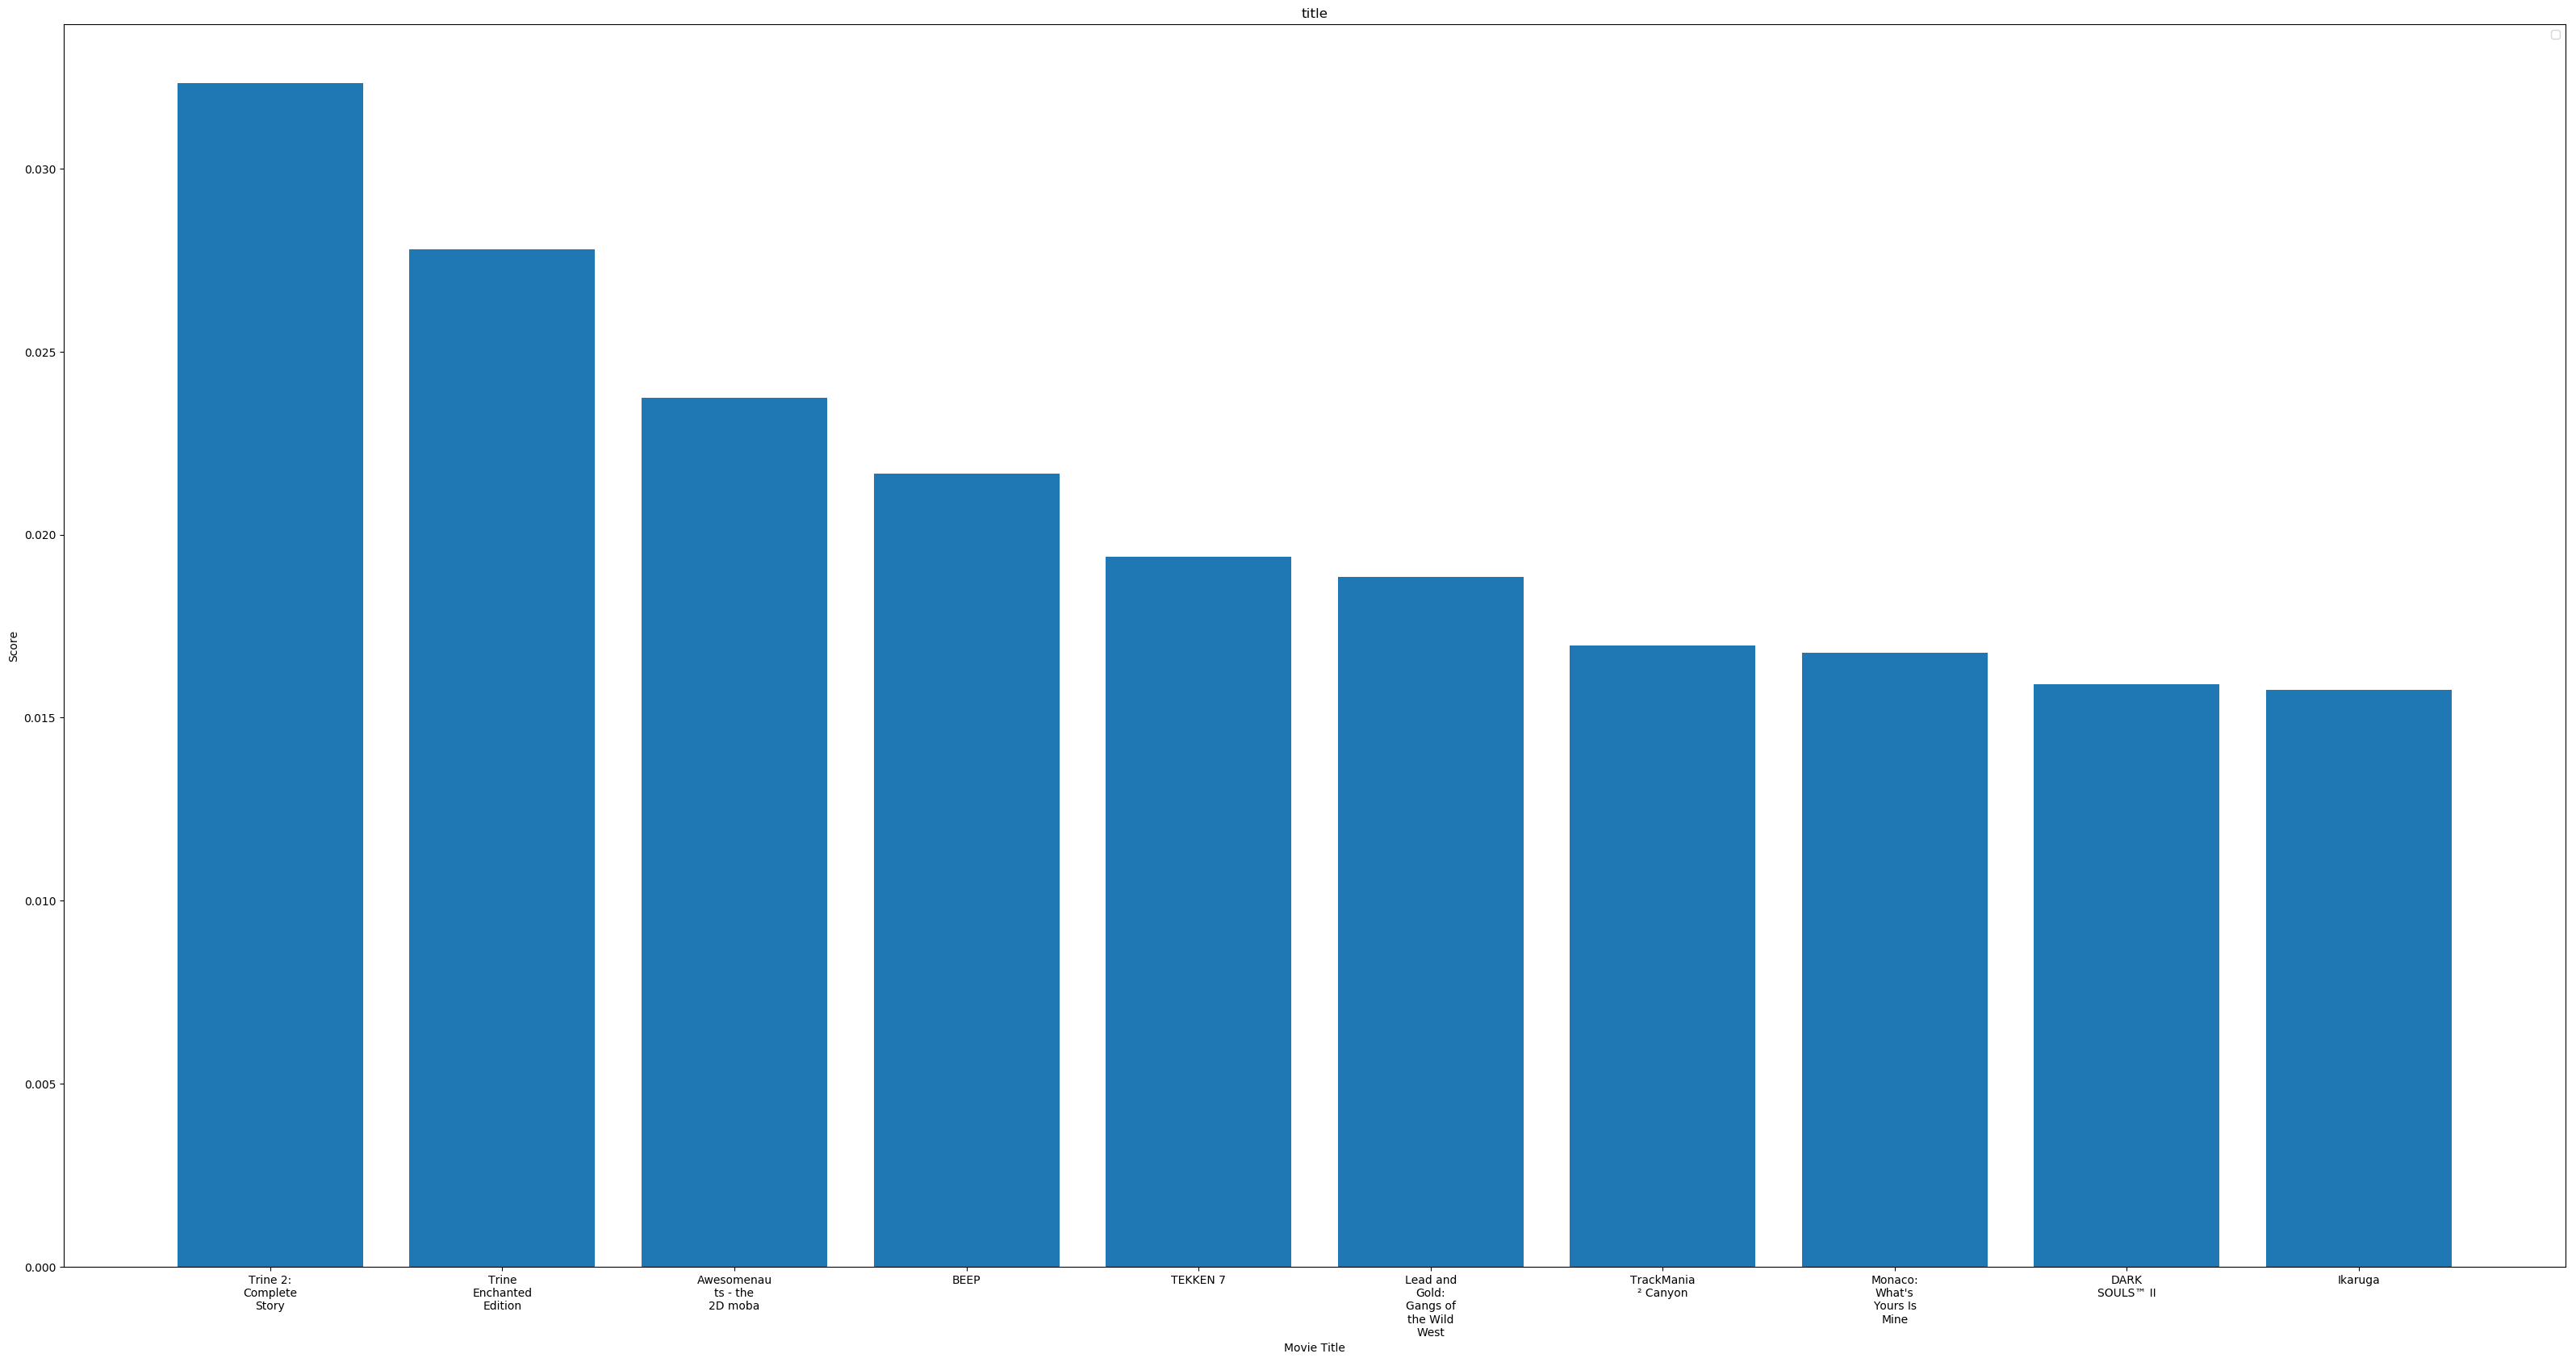

In [114]:
from textwrap import wrap

titles = np.array(topgames)[0:10]
score = np.array(topgames['score'])
# print(titles.shape)
# print(score.shape)

titles = [ '\n'.join(wrap(l, 10)) for l in titles ]

from pylab import rcParams
rcParams['figure.figsize'] = 40,20

ind = np.arange(1,len(score)+1)
# print(ind)
plt.title("title")
plt.ylabel("Score")
plt.xlabel("Movie Title")
plt.bar(ind, score,tick_label=titles, align = 'center')
plt.legend()
plt.show()

In [46]:
r = Rake()
r.extract_keywords_from_text(cs)
key_words_dict_scores = r.get_word_degrees()

In [49]:
ds[list(key_words_dict_scores.keys())

['counter',
 'team',
 'go',
 'features',
 'new',
 'maps',
 'global',
 'offensive',
 'based',
 'action',
 'gameplay',
 'strike',
 'expands',
 'upon',
 'de_dust2',
 'pioneered',
 'delivers',
 'updated',
 'versions',
 'game',
 'modes',
 'characters',
 'weapons',
 'etc',
 'cs',
 'classic',
 'content',
 ').',
 'launched',
 '19',
 'years',
 'ago']